In [39]:
import Pkg
Pkg.add("Plots")
Pkg.add("LinearAlgebra")
Pkg.add("SymPy")
Pkg.add("ForwardDiff")

   Resolving package versions...
  No Changes to `C:\Users\Anastasia\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Anastasia\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Anastasia\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Anastasia\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Anastasia\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Anastasia\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Anastasia\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Anastasia\.julia\environments\v1.10\Manifest.toml`


In [40]:
using Plots
using LinearAlgebra

function df(f, x::Vector{Float64}, i, h=1e-5)
    x_plus = copy(x)
    x_minus = copy(x)
    
    x_plus[i] += h
    x_minus[i] -= h
    
    df_dx = (f(x_plus) - f(x_minus)) / (2h)
    
    return df_dx
end

function gradient(f, x::Vector{Float64})
    grad = []
    for i in 1:length(x)
        push!(grad, df(f, x, i))
    end
    df_dx = grad[1]
    df_dy = grad[2]
    return [df_dx x[2]; df_dy x[2]]
end

gradient (generic function with 1 method)

In [58]:
using SymPy
x, y = symbols("x y")

# функция по варианту
my_func = (x-4*y)^2 + (y+5)^2

function find_grad(point)
    df_dx = diff(my_func, x)    
    df_dy = diff(my_func, y)
    return [df_dx.subs([(x,point[1]), (y, point[2])]), df_dy.subs([(x,point[1]), (y, point[2])])]
end

find_grad([1.0, 0.0])

2-element Vector{Sym{PyCall.PyObject}}:
 2.00000000000000
 2.00000000000000

In [42]:
using LinearAlgebra

function swann_method(f, x0, h=0.1)
    first = x0
    second = x0 + h
    # если функция растет, меняем направление движения
    if f(second) > f(first)
        h = -h
        first, second = second, second + h
    end
    last = second + h
    
    # увеличиваем шаг движения, если функция уменьшается
    while f(last) < f(second)
        h *= 2
        first, second, last = second, last, last + h
    end
    # перепрыгнули далеко
    if second > last
        first, second, last = last, second, first
    end

    return first, last
end

function golden_section_search(f, a, b, eps=1e-5)
    phi = (sqrt(5) - 1) / 2 
    x1 = b - phi * (b - a)
    x2 = a + phi * (b - a)
    
    while abs(b - a) > eps
        if f(x1) <= f(x2)
            b = x2
        else
            a = x1
        end
        x1 = b - phi * (b - a)
        x2 = a + phi * (b - a)
    end
    
    return (a + b) / 2
end

golden_section_search (generic function with 2 methods)

In [43]:
# функция Розенброка
# func(x, y) = (1 - x)^2 + 100(y - x^2)^2
# f(x) = func(x[1],x[2])

func(x, y) = (x-4*y)^2 +(y+5)^2
f(x) = func(x[1],x[2])
x0 = [10.0, -5.0]

2-element Vector{Float64}:
 10.0
 -5.0

### Метод Пирсона 1

In [44]:
using Plots
using LinearAlgebra

function pirson_1(x_start, eps)
    x = x_start
    trajectory = [x]
    gradient = find_grad(x)
    H = [1 0; 0 1]
    prev_x = x
    prev_grad = gradient
    alpha = 0.01
    while norm(gradient) > eps
        s = H * gradient
#         l, r = swann_method(alpha -> f(x - alpha * s), 1e-2)
#         alpha = golden_section_search(alpha -> f(x - alpha * s),  l,  r)
        x_new = [x[1] - alpha * s[1], x[2] - alpha * s[2]]
        prev_x = x
        x = x_new
        push!(trajectory, x)
        
        prev_grad = gradient
        gradient = find_grad(x)
        d_x = [x[1] - prev_x[1], x[2] - prev_x[2]]
        delta_g = [gradient[1] - prev_grad[1], gradient[2] - prev_grad[2]]
        N = (d_x - H * delta_g) * transpose(d_x) / dot(transpose(d_x), delta_g)
        H = H + N
    end
    
    return trajectory
end

pirson_1 (generic function with 1 method)

Метод Пирсона 1:
 точка минимума: [-19.999999802805906, -4.999999982020858]
 кол-во итераций = 1880


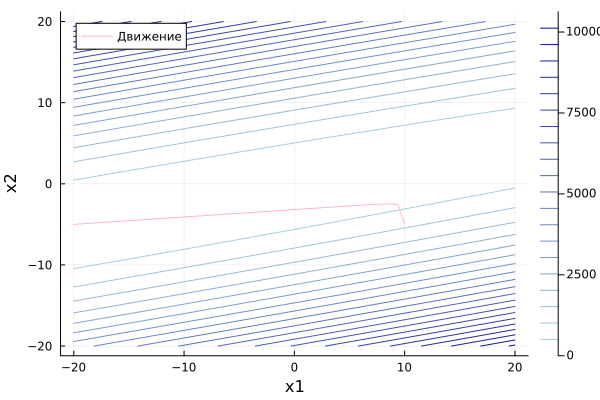

In [45]:
trajectory = pirson_1(x0, 0.000001)
x_min = trajectory[end]
println("Метод Пирсона 1:\n точка минимума: $x_min\n кол-во итераций = $(length(trajectory)-1)")

contour_range = -20:0.1:20
contour_plot = contour(contour_range, contour_range, (x, y) -> (x-4*y)^2 +(y+5)^2, levels=20, c=:blues)
plot!([point[1] for point in trajectory], [point[2] for point in trajectory], label="Движение", c=:reds)
plot!(xlabel="x1", ylabel="x2")

### Метод Пирсона 2

In [46]:
using Plots
using LinearAlgebra

function pirson_2(x_start, eps)
    x = x_start
    trajectory = [x]
    gradient = find_grad(x)
    H = [1 0; 0 1]
    prev_x = x
    prev_grad = gradient
    
    while norm(gradient) > eps
        s = H * gradient
        l, r = swann_method(alpha -> f(x - alpha * s), 1e-2)
        alpha = golden_section_search(alpha -> f(x - alpha * s),  l,  r)
        x_new = [x[1] - alpha * s[1], x[2] - alpha * s[2]]
        prev_x = x
        x = x_new
        push!(trajectory, x)
        
        prev_grad = gradient
        gradient = find_grad(x)
        d_x = [x[1] - prev_x[1], x[2] - prev_x[2]]
        delta_g = [gradient[1] - prev_grad[1], gradient[2] - prev_grad[2]]
        N = (d_x - H * delta_g) * transpose(d_x) / dot(transpose(d_x), delta_g)
        H = H + N
    end
    
    return trajectory
end

pirson_2 (generic function with 1 method)

Метод Пирсона 2:
 точка минимума: [-19.999999648901706, -4.999999916237441]
 кол-во итераций = 5


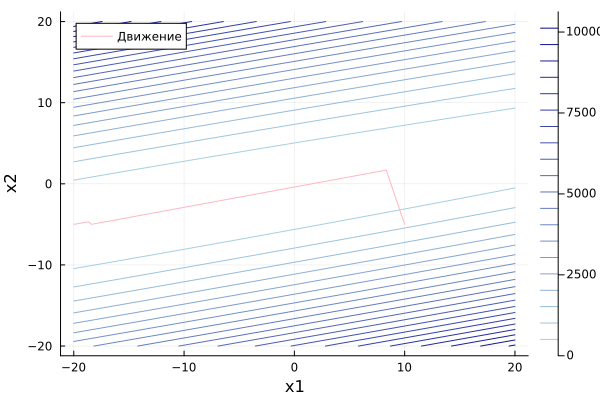

In [59]:
trajectory = pirson_2(x0, 0.001)
x_min = trajectory[end]
println("Метод Пирсона 2:\n точка минимума: $x_min\n кол-во итераций = $(length(trajectory)-1)")

contour_range = -20:0.1:20
contour_plot = contour(contour_range, contour_range, (x, y) -> (x-4*y)^2 +(y+5)^2, levels=20, c=:blues)
plot!([point[1] for point in trajectory], [point[2] for point in trajectory], label="Движение", c=:reds)
plot!(xlabel="x1", ylabel="x2")

### Метод Пирсона 3

In [48]:
using Plots
using LinearAlgebra

function pirson_3(x_start, eps)
    x = x_start
    trajectory = [x]
    gradient = find_grad(x)
    H = [1 0; 0 1]
    prev_x = x
    prev_grad = gradient
    
    while norm(gradient) > eps
        s = H * gradient
        l, r = swann_method(alpha -> f(x - alpha * s), 1e-2)
        alpha = golden_section_search(alpha -> f(x - alpha * s),  l,  r)
        x_new = [x[1] - alpha * s[1], x[2] - alpha * s[2]]
        prev_x = x
        x = x_new
        push!(trajectory, x)
        
        prev_grad = gradient
        gradient = find_grad(x)
        d_x = [x[1] - prev_x[1], x[2] - prev_x[2]]
        delta_g = [gradient[1] - prev_grad[1], gradient[2] - prev_grad[2]]
        N = (d_x - H * delta_g) * transpose((H * delta_g)) / dot(transpose(delta_g), H * delta_g)
        H = H + N
    end
    
    return trajectory
end

pirson_3 (generic function with 1 method)

Метод Пирсона 3:
 точка минимума: [-19.9999999994923, -4.9999999998837845]
 кол-во итераций = 5


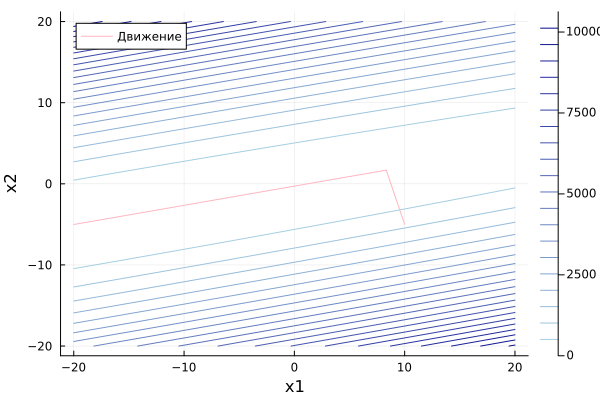

In [49]:
trajectory = pirson_3(x0, 1e-6)
x_min = trajectory[end]
println("Метод Пирсона 3:\n точка минимума: $x_min\n кол-во итераций = $(length(trajectory)-1)")

contour_range = -20:0.1:20
contour_plot = contour(contour_range, contour_range, (x, y) -> (x-4*y)^2 +(y+5)^2, levels=20, c=:blues)
plot!([point[1] for point in trajectory], [point[2] for point in trajectory], label="Движение", c=:reds)
plot!(xlabel="x1", ylabel="x2")

### Метод Ньютона-Рафсона

In [50]:
using Plots
using LinearAlgebra

function newtone_rafson(x_start, eps)
    x = x_start
    trajectory = [x]
    gradient = find_grad(x)
    H = [1 0; 0 1]
    prev_x = x
    prev_grad = gradient
    
    while norm(gradient) > eps
        s = H * gradient
        l, r = swann_method(alpha -> f(x - alpha * s), 1e-2)
        alpha = golden_section_search(alpha -> f(x - alpha * s),  l,  r)
        x_new = [x[1] - alpha * s[1], x[2] - alpha * s[2]]
        prev_x = x
        x = x_new
        push!(trajectory, x)
        
        prev_grad = gradient
        gradient = find_grad(x)
        d_x = [x[1] - prev_x[1], x[2] - prev_x[2]]
        delta_g = [gradient[1] - prev_grad[1], gradient[2] - prev_grad[2]]
        N = (H * delta_g) * transpose((H * delta_g)) / dot(transpose(delta_g), H * delta_g)
        H = H - N
    end
    
    return trajectory
end

newtone_rafson (generic function with 1 method)

Метод Ньютона-Рафсона:
 точка минимума: [-20.000131717104438, -4.9994805077455515]
 кол-во итераций = 4


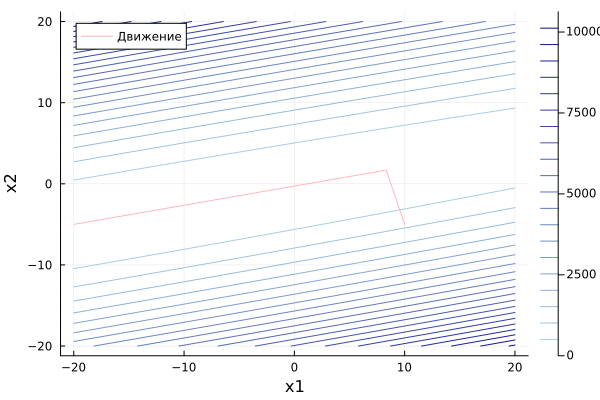

In [51]:
trajectory = newtone_rafson(x0, 1e-6)
x_min = trajectory[end-1]
println("Метод Ньютона-Рафсона:\n точка минимума: $x_min\n кол-во итераций = $(length(trajectory)-1)")

contour_range = -20:0.1:20
contour_plot = contour(contour_range, contour_range, (x, y) -> (x-4*y)^2 +(y+5)^2, levels=20, c=:blues)
plot!([point[1] for point in trajectory], [point[2] for point in trajectory], label="Движение", c=:reds)
plot!(xlabel="x1", ylabel="x2")

### Методы Гринштадта и Гольдфарба

In [52]:
using Plots
using LinearAlgebra
using ForwardDiff

function greenshtadt(x_start, eps)
    x = x_start
    trajectory = [x]
    gradient = find_grad(x)
    H = [1 0; 0 1]
    prev_x = x
    prev_grad = gradient
    it = 0
    while norm(gradient) > eps
        it += 1
#         if it > 100
#             break
#         end
        s = H * gradient
        l, r = swann_method(alpha -> f(x - alpha * s), 1e-2)
        alpha = golden_section_search(alpha -> f(x - alpha * s),  l,  r)
        x_new = [x[1] - alpha * s[1], x[2] - alpha * s[2]]
        prev_x = x
        x = x_new
        push!(trajectory, x)
        
        prev_grad = gradient
        gradient = find_grad(x)
        d_x = [x[1] - prev_x[1], x[2] - prev_x[2]]
        delta_g = [gradient[1] - prev_grad[1], gradient[2] - prev_grad[2]]
        
        multiplier = 1 / dot(transpose(delta_g), H * delta_g)
        first_add = d_x*transpose(delta_g)*H+H*delta_g*transpose(d_x)
        second_chisl_multyp = transpose(delta_g)*d_x - transpose(delta_g)*H*delta_g
        second_chisl_multyp_2 = H*delta_g*transpose(delta_g)*H
        second_chisl_multyp = second_chisl_multyp*second_chisl_multyp_2
        znam_second = dot(transpose(delta_g),H*delta_g)
        second_add = second_chisl_multyp/znam_second
        first_add = first_add-second_add
        N = first_add * multiplier
        H = H - N
    end
    
    return trajectory
end

greenshtadt (generic function with 1 method)

Метод Гринштадта:
 точка минимума: [-20.000000006821168, -4.999999991047872]
 кол-во итераций = 3


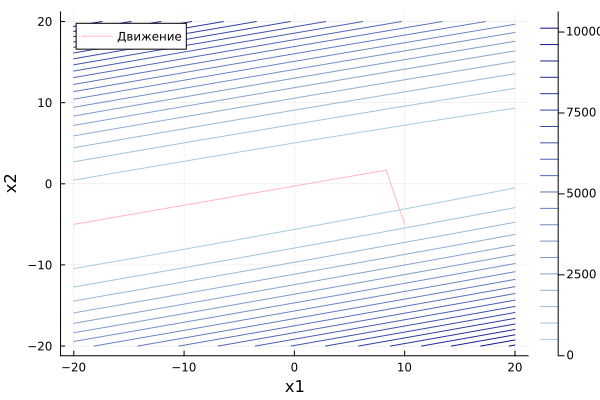

In [53]:
x0 = [10.0, -5.0]
trajectory = greenshtadt(x0,  1e-3)
x_min = trajectory[end]
println("Метод Гринштадта:\n точка минимума: $x_min\n кол-во итераций = $(length(trajectory)-1)")

contour_range = -20:0.1:20
contour_plot = contour(contour_range, contour_range, (x, y) -> (x-4*y)^2 +(y+5)^2, levels=20, c=:blues)
plot!([point[1] for point in trajectory], [point[2] for point in trajectory], label="Движение", c=:reds)
plot!(xlabel="x1", ylabel="x2")

In [54]:
function goldfarb(x_start, eps)
    x = x_start
    trajectory = [x]
    gradient = find_grad(x)
    H = [1 0; 0 1]
    prev_x = x
    prev_grad = gradient
    
    it = 0
    while norm(gradient) > eps
#         it += 1
#         if it > 100
#             break
#         end
        s = H * gradient
        l, r = swann_method(alpha -> f(x - alpha * s), 1e-2)
        alpha = golden_section_search(alpha -> f(x - alpha * s),  l,  r)
        x_new = [x[1] - alpha * s[1], x[2] - alpha * s[2]]
        prev_x = x
        x = x_new
        push!(trajectory, x)
        
        prev_grad = gradient
        gradient = find_grad(x)
        d_x = [x[1] - prev_x[1], x[2] - prev_x[2]]
        delta_g = [gradient[1] - prev_grad[1], gradient[2] - prev_grad[2]]
        
        multiplier = 1 / dot(transpose(delta_g), H * delta_g)
        first = d_x*transpose(delta_g)*H + H*delta_g*transpose(d_x)
        
        ss = transpose(delta_g)*d_x
        sss = H * delta_g * transpose(delta_g) * H
        second = 1 + ss/dot(transpose(delta_g), H*delta_g)
        second = second * sss 
        N = multiplier * (first - second)
        H = H + N
    end
    
    return trajectory
end

goldfarb (generic function with 1 method)

Метод Гольдфарба:
 точка минимума: [-20.000000001173138, -4.999999992205972]
 кол-во итераций = 3


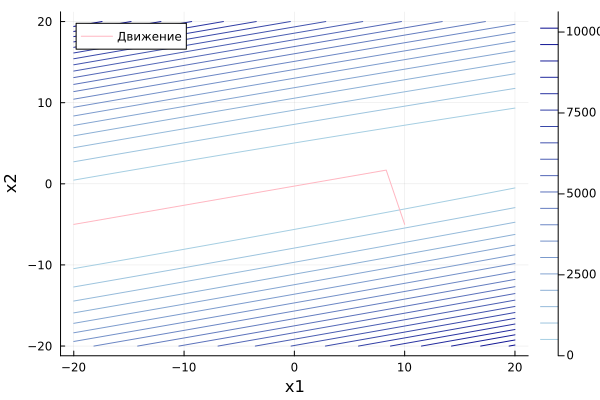

In [55]:
trajectory = goldfarb(x0, 0.001)
x_min = trajectory[end]
println("Метод Гольдфарба:\n точка минимума: $x_min\n кол-во итераций = $(length(trajectory)-1)")

contour_range = -20:0.1:20
contour_plot = contour(contour_range, contour_range, (x, y) -> (x-4*y)^2 +(y+5)^2, levels=20, c=:blues)
plot!([point[1] for point in trajectory], [point[2] for point in trajectory], label="Движение", c=:reds)
plot!(xlabel="x1", ylabel="x2")

### Метод Флетчера

In [56]:
using Plots
using LinearAlgebra

function fletcher(x_start, eps)
    x = x_start
    trajectory = [x]
    gradient = find_grad(x)
    H = [1 0; 0 1]
    prev_x = x
    prev_grad = gradient
    
    while norm(gradient) > eps
        s = H * gradient
        l, r = swann_method(alpha -> f(x - alpha * s), 1e-2)
        alpha = golden_section_search(alpha -> f(x - alpha * s),  l,  r)
        x_new = [x[1] - alpha * s[1], x[2] - alpha * s[2]]
        prev_x = x
        x = x_new
        push!(trajectory, x)
        
        prev_grad = gradient
        gradient = find_grad(x)
        del_x = [x[1] - prev_x[1], x[2] - prev_x[2]]
        delta_g = [gradient[1] - prev_grad[1], gradient[2] - prev_grad[2]]
        
        first_mnog = 1 / dot(transpose(delta_g), H*delta_g)
        first_add = d_x*transpose(delta_g)*H + H*delta_g*transpose(d_x)
        second_multy_chisl = transpose(delta_g) * delta_x
        second_multy_znam = dot(transpose(delta_g), H*delta_g)
        second_multy_chisl = second_multy_chisl/second_multy_znam
        sec_2 = 1 + second_multy_chisl
        sec_3 = H * delta_g * transpose(delta_g)*H
        second_add = sec_2 * sec_3
        chisl=first_add-second_add
        E = [1 0; 0 1]
        first_chisl = d_x * transpose(delta_g)
        first_znam = dot(transpose(d_x), delta_g)
        first_mnog = first_chisl / first_znam
        first_mnog = E - first_mnog
        
        second_chisl = delta_g * transpose(d_x)
        second_znam = dot(transpose(d_x), delta_g)
        second_mnog = second_chisl / second_znam
        second_mnog = E - second_mnog
        
        N = first_mnog * H * second_mnog
        chisl = d_x * transpose(d_x)
        znam = dot(transpose(d_x), delta_g)
        H = N + chisl / znam
    end
    
    return trajectory
end

fletcher (generic function with 1 method)

Метод Флетчера:
 точка минимума: [-19.9999999995769, -5.0000000013060335]
 кол-во итераций = 3


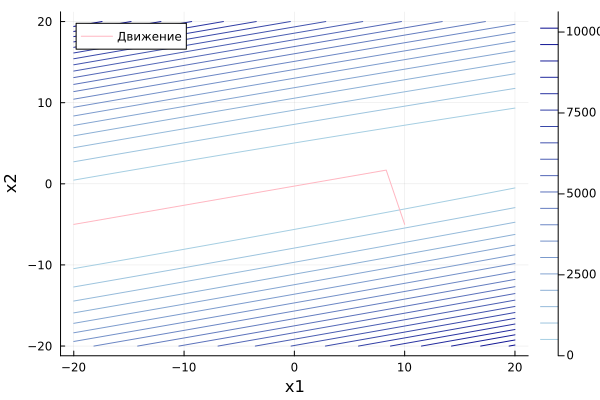

In [57]:
trajectory = fletcher(x0, 1e-6)
x_min = trajectory[end]
println("Метод Флетчера:\n точка минимума: $x_min\n кол-во итераций = $(length(trajectory)-1)")

contour_range = -20:0.1:20
contour_plot = contour(contour_range, contour_range, (x, y) -> (x-4*y)^2 +(y+5)^2, levels=20, c=:blues)
plot!([point[1] for point in trajectory], [point[2] for point in trajectory], label="Движение", c=:reds)
plot!(xlabel="x1", ylabel="x2")